In [1]:
import pandas as pd
import numpy as np
import env
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, RFE, f_regression, SequentialFeatureSelector
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LassoLars
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import TweedieRegressor
import wrangle
import warnings
warnings.filterwarnings("ignore")
import scipy.stats as stats

# Acquire
- Data acquiured from SQL database
- it contained 53031 rows and 6 columns
- Each row represents a single family home
- Each column represents a catagory of data

# Prepare
- checked that the column datatypes were appropriate
- droped the unnamed: 0 column
- created a boolean mask to find calculated square feet values under 25000
- cut the top 5% of taxvaluedollar count
- dropped the na values
- converted calculatedfinishedsquarefeet, fips and yearbuilt to int's
- Split data into train, validate and test (approx. 60/20/20)

In [2]:
df = pd.read_csv('zillow_data.csv')

df = wrangle.preparing_data_zillow(df)
df = df.drop(columns ='fips')

In [3]:
df

,taxvaluedollarcnt,calculatedfinishedsquarefeet,bedroomcnt,bathroomcnt,yearbuilt
0,113382.0,1045,3.0,2.0,1992
1,116882.0,1807,4.0,2.0,1994
2,187178.0,1766,4.0,2.0,1993
3,184923.0,1672,3.0,2.0,1991
4,218000.0,1490,3.0,2.0,1992
...,...,...,...,...,...
56075,277073.0,2123,5.0,3.0,1965
56076,238731.0,1192,3.0,2.0,1966
56077,208237.0,1633,3.0,3.0,1965
56078,102470.0,1824,5.0,3.0,1965


In [4]:
train, validate, test = wrangle.split_data(df, 'taxvaluedollarcnt')

In [5]:
X_train, X_validate, X_test, y_train, y_validate, y_test = wrangle.get_X_train_val_test(train, validate, test,'taxvaluedollarcnt', 'taxvaluedollarcnt' )

# A brief look at the data

In [6]:
train.head()

,taxvaluedollarcnt,calculatedfinishedsquarefeet,bedroomcnt,bathroomcnt,yearbuilt
40395,642246.0,2790,4.0,2.0,2015
7365,673516.0,2300,5.0,4.0,1973
40927,150311.0,807,3.0,1.0,1924
43093,334977.0,1796,3.0,2.0,1963
29787,343554.0,1828,4.0,2.0,1979


# A summary of the data

In [7]:
train.describe()

,taxvaluedollarcnt,calculatedfinishedsquarefeet,bedroomcnt,bathroomcnt,yearbuilt
count,3.181800e+04,31818.000000,31818.000000,31818.000000,31818.000000
mean,3.631247e+05,1754.951317,3.254793,2.145719,1960.306022
std,2.457540e+05,721.495540,0.898386,0.835019,21.384375
min,1.050000e+02,20.000000,0.000000,0.000000,1862.000000
25%,1.786985e+05,1242.000000,3.000000,2.000000,1949.000000
50%,3.122540e+05,1592.000000,3.000000,2.000000,1958.000000
75%,4.923950e+05,2117.000000,4.000000,3.000000,1974.000000
max,1.206863e+06,9200.000000,9.000000,8.000000,2016.000000


In [8]:
train['year_bins'] = pd.qcut(X_train.yearbuilt, q = 4, precision=0).astype('str')

In [9]:
BIN_1949_1958 = train[train['year_bins'] == '(1949.0, 1958.0]']
BIN_1861_1949 = train[train['year_bins'] == '(1861.0, 1949.0]']
BIN_1958_1974 = train[train['year_bins'] == '(1958.0, 1974.0]']
BIN_1974_2016 = train[train['year_bins'] == '(1974.0, 2016.0]']

# Does Tax-value-dollar-count increase over time

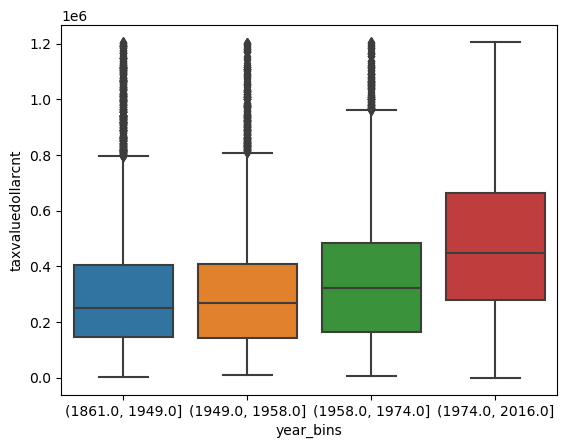

In [10]:
sns.boxplot(train, x= train['year_bins'], y =train['taxvaluedollarcnt'], order = ['(1861.0, 1949.0]','(1949.0, 1958.0]','(1958.0, 1974.0]','(1974.0, 2016.0]'])
plt.show()

- The average of tax value dollar count has went up over the years

<br>
- we assume a normal distribution because of the amount of samples being over 500
<br>
<b>I will now use an anova test to investigate if tax value dollar count has went up over the years.</b>
<br>
- I will use a confidence interval of 95%
- the resulting alpha is .05

<b>Ho: The mean of tax value dollar count has not changed over the years</b>

<b>Ha: The mean of tax value dollar count has changed over the years</b>

In [11]:
t, p = stats.f_oneway(BIN_1949_1958.taxvaluedollarcnt, BIN_1861_1949.taxvaluedollarcnt,BIN_1958_1974.taxvaluedollarcnt, BIN_1974_2016.taxvaluedollarcnt)
print('we reject the null hypothesis because', p, '< alpha')

we reject the null hypothesis because 0.0 < alpha


# Does number of bedrooms affect tax value dollar count

In [12]:
train['bedroom_bins'] = pd.cut(X_train.bedroomcnt, bins = 4).astype('str')


BIN_0_2_5 = train[train['bedroom_bins'] == '(-0.009, 2.25]']
BIN_45675 = train[train['bedroom_bins'] == '(4.5, 6.75]']
BIN_22545 = train[train['bedroom_bins'] == '(2.25, 4.5]']
BIN_679 = train[train['bedroom_bins'] == '(6.75, 9.0]']

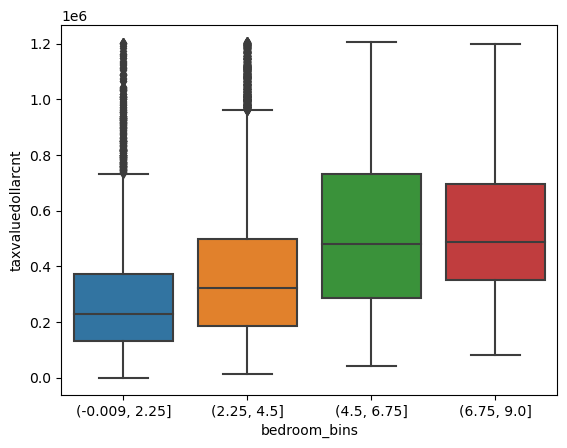

In [13]:
sns.boxplot(train, x= train['bedroom_bins'], y =train['taxvaluedollarcnt'], order = ['(-0.009, 2.25]','(2.25, 4.5]','(4.5, 6.75]','(6.75, 9.0]'])
plt.show()

- The average of tax value dollar count is higher the more bathrooms a home posseses

<br>
- we assume a normal distribution because of the amount of samples being over 500
<br>
<b>I will now use an anova test to investigate if tax value dollar count is higher based on bathrooms.</b>
<br>
- I will use a confidence interval of 95%
- the resulting alpha is .05

<b>Ho: The mean of tax value dollar count is the same no matter how many bedrooms a home posseses</b>

<b>Ha: The mean of tax value dollar count is different based on number of bedrooms</b>

In [14]:
t, p = stats.f_oneway(BIN_0_2_5.taxvaluedollarcnt, BIN_22545.taxvaluedollarcnt, BIN_45675.taxvaluedollarcnt, BIN_679.taxvaluedollarcnt)
print('we reject the null hypothesis because', p, '< alpha')

we reject the null hypothesis because 0.0 < alpha


# Does the size of the house affect the tax value dollar count

In [15]:
train['size_bins'] = pd.qcut(X_train.calculatedfinishedsquarefeet, q = 4).astype('str')
train['size_bins'].value_counts()

(1242.0, 1592.0]    7969
(19.999, 1242.0]    7960
(2117.0, 9200.0]    7949
(1592.0, 2117.0]    7940
Name: size_bins, dtype: int64

In [16]:
size_19999_1242 = train[train['size_bins'] == '(19.999, 1242.0]']
size_1242_1592 = train[train['size_bins'] == '(1242.0, 1592.0]']
size_1592_2117 = train[train['size_bins'] == '(1592.0, 2117.0]']
size_2117_9200 = train[train['size_bins'] == '(2117.0, 9200.0]']

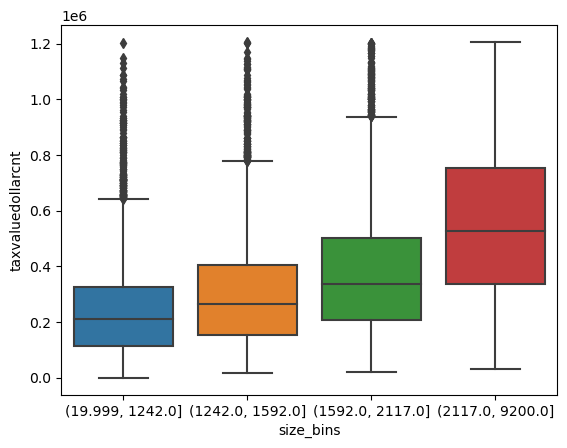

In [17]:
sns.boxplot(train, x= train['size_bins'], y =train['taxvaluedollarcnt'], order = ['(19.999, 1242.0]','(1242.0, 1592.0]','(1592.0, 2117.0]','(2117.0, 9200.0]'])
plt.show()
# 160 square feet minimun update under prepare

- The average of tax value dollar count is higher the more square feet a home posseses

<br>
- we assume a normal distribution because of the amount of samples being over 500
<br>
<b>I will now use an anova test to investigate if tax value dollar count is higher based on squarefeet of the home.</b>
<br>
- I will use a confidence interval of 95%
- the resulting alpha is .05

<b>Ho: The mean of tax value dollar count is the same no matter how many square feet a home posseses</b>

<b>Ha: The mean of tax value dollar count is different based on size of the house</b>

In [18]:
t, p = stats.f_oneway(size_19999_1242.taxvaluedollarcnt, size_1242_1592.taxvaluedollarcnt, size_1592_2117.taxvaluedollarcnt, size_2117_9200.taxvaluedollarcnt)
print('we reject the null hypothesis because', p, '< alpha')

we reject the null hypothesis because 0.0 < alpha


# Does bathroom count affect the taxvalue dollar count of a home

In [19]:
train['bathroom_bins'] = pd.cut(X_train.bathroomcnt, bins= 4).astype('str')
train['bathroom_bins'].value_counts()

(-0.008, 2.0]    21409
(2.0, 4.0]        9938
(4.0, 6.0]         457
(6.0, 8.0]          14
Name: bathroom_bins, dtype: int64

In [20]:
bath_0_2 = train[train['bathroom_bins'] == '(-0.008, 2.0]']
bath_2_4 = train[train['bathroom_bins'] == '(2.0, 4.0]']
bath_4_6 = train[train['bathroom_bins'] == '(4.0, 6.0]']
bath_6_8 = train[train['bathroom_bins'] == '(6.0, 8.0]']

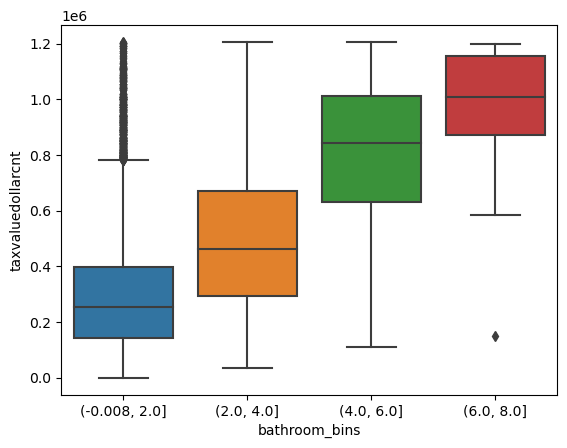

In [21]:
sns.boxplot(train, x= train['bathroom_bins'], y =train['taxvaluedollarcnt'], order = ['(-0.008, 2.0]','(2.0, 4.0]','(4.0, 6.0]','(6.0, 8.0]'])
plt.show()

- The average of tax value dollar count is higher bathrooms a home posseses

<br>
- we assume a normal distribution because of the amount of samples being over 500
<br>
<b>I will now use an anova test to investigate if tax value dollar count is higher based on number of bathrooms in a home.</b>
<br>
- I will use a confidence interval of 95%
- the resulting alpha is .05

<b>Ho: The mean of tax value dollar count is the same no matter how many bathrooms a home posseses</b>

<b>Ha: The mean of tax value dollar count is different based on number of bathrooms in the house</b>

In [22]:
t, p = stats.f_oneway(bath_0_2.taxvaluedollarcnt, bath_2_4.taxvaluedollarcnt, bath_4_6.taxvaluedollarcnt, bath_6_8.taxvaluedollarcnt)
print('we reject the null hypothesis because', p, '< alpha')

we reject the null hypothesis because 0.0 < alpha


## Exploratory Summary

<b>tax value dollar count was affected by</b>
- calculated square feet 
- bathroom count
- bedroom count
- year built

## Features I am moving to modeling With

- calculated square feet 
- bathroom count
- bedroom count
- year built

## Modeling

- I will be scaling my data with a robust scaler

** I will be evaluating models developed using four different model types and various hyperparameter configurations * Models will be evaluated on train and validate data * The model that performs the best will then be evaluated on test data

In [23]:
X_train_columns = X_train.columns
X_validate_columns = X_validate.columns
X_test_columns = X_test.columns
X_train_numbers, X_validade_numbers, X_test_numbers = wrangle.scaler_robust(X_train, X_validate, X_test)

In [24]:
X_train_scaled = pd.DataFrame(columns = X_train_columns)
for i in range(int(X_train_numbers.shape[0])):
    X_train_scaled.loc[len(X_train_scaled.index)] = X_train_numbers[i]
    
X_validate_scaled = pd.DataFrame(columns = X_validate_columns)
for i in range(int(X_validade_numbers.shape[0])):
    X_validate_scaled.loc[len(X_validate_scaled.index)] = X_validade_numbers[i]
    
X_test_scaled = pd.DataFrame(columns = X_test_columns)
for i in range(int(X_test_numbers.shape[0])):
    X_test_scaled.loc[len(X_test_scaled.index)] = X_test_numbers[i]


In [25]:
X_validate_scaled

,calculatedfinishedsquarefeet,bedroomcnt,bathroomcnt,yearbuilt
0,-0.034652,0.0,0.0,0.086957
1,1.874675,2.0,1.0,2.086957
2,-0.128213,0.0,0.0,-0.521739
3,-0.049668,0.0,0.0,1.304348
4,1.036096,1.0,1.0,-0.217391
...,...,...,...,...
10601,0.827029,1.0,1.0,0.956522
10602,1.657522,1.0,2.0,-0.043478
10603,0.629512,1.0,1.0,0.869565
10604,-0.487439,0.0,0.0,0.086957


In [26]:
metrics_train_df, metrics_validate_df = wrangle.get_model_numbers(X_train, X_validate, X_test, y_train, y_validate, y_test)

In [27]:
metrics_train_df

,model_train,rmse,r2
0,baseline,245750.179222,0.000000e+00
1,ordinary least squared(OLS),205586.468046,3.001558e-01
2,lasso lars(lars),205586.468066,3.001558e-01
3,Polynomial Regression(poly2),204061.535087,3.104995e-01
4,Generalized Linear Model (GLM),245750.179222,1.110223e-16


In [35]:
metrics_validate_df

,model_validate,rmse,r2
0,baseline,245750.179222,0.000000
1,ordinary least squared(OLS),205890.917703,0.281893
2,lasso lars(lars),205890.980752,0.281892
3,Polynomial Regression(poly2),204238.056746,0.293376
4,Generalized Linear Model (GLM),242968.350000,-0.000000


# Conclusions

## explore recap
- calculated finished square feet affect tax value dollar count
- bathroom count affect tax value dollar count
- bedroom count affect tax value dollar count
- year built affect tax value dollar count
    - The average of tax value dollar count has went up over the years
    - The average of tax value dollar count is higher the more bedrooms a home posseses
    - The average of tax value dollar count is higher the more square feet a home posseses
    - The average of tax value dollar count is higher bathrooms a home posseses


## Modeling Summary
- Polynomial Regression performed best
    - rmse of 204238 
    - r2 score of 
- lasso lars and ordinary least squared performed second best
    - rmse scores of 205586 
    - r2 scores of 28
- Generalized Linear Model performed worst at
    - 242968 rmse
    - 0 r2 score

## Solution

- Since the top model only performed 30% at best we cannot move forward with it
- The solution would be to continue onto next steps in hopes of creating a better model

# next steps

- look for more things that affect tax value dollar count
- break the catagories up by location subcatagories
- imput new columns of information into my modeling tests